In [23]:
import argparse
import gym
from gym import wrappers
import os.path as osp
import random
import numpy as np
import itertools
import tensorflow as tf
import tensorflow.contrib.layers as layers

import os
import sys
nb_dir = os.path.split(os.getcwd())[0]
if nb_dir not in sys.path:
    sys.path.append(nb_dir)
#from utils import plotting

import dqn
from dqn_utils import *
#from atari_wrappers import *
#from environments.arm_env.arm_env import ArmEnv
from arm_env_dqn import ArmEnvDQN
import plotting

In [24]:
def arm_model(img_in, num_actions, scope, reuse=False):
    # as described in https://storage.googleapis.com/deepmind-data/assets/papers/DeepMindNature14236Paper.pdf
    with tf.variable_scope(scope, reuse=reuse):
        out = img_in
        with tf.variable_scope("convnet"):
            # original architecture
            out = layers.convolution2d(out, num_outputs=32, kernel_size=8, stride=4, activation_fn=tf.nn.relu)
            out = layers.convolution2d(out, num_outputs=64, kernel_size=4, stride=2, activation_fn=tf.nn.relu)
            out = layers.convolution2d(out, num_outputs=64, kernel_size=3, stride=1, activation_fn=tf.nn.relu)
        out = layers.flatten(out)
        with tf.variable_scope("action_value"):
            out = layers.fully_connected(out, num_outputs=256,         activation_fn=tf.nn.relu)
            out = layers.fully_connected(out, num_outputs=num_actions, activation_fn=None)

        return out


def arm_learn(env, session, num_timesteps):
    # This is just a rough estimate
    num_iterations = float(num_timesteps) / 4.0

    lr_multiplier = 1.0
    lr_schedule = PiecewiseSchedule([
                                         (0,                   1e-4 * lr_multiplier),
                                         (num_iterations / 10, 1e-4 * lr_multiplier),
                                         (num_iterations / 2,  5e-5 * lr_multiplier),
                                    ],
                                    outside_value=5e-5 * lr_multiplier)
    optimizer = dqn.OptimizerSpec(
        constructor=tf.train.AdamOptimizer,
        kwargs=dict(epsilon=1e-4),
        lr_schedule=lr_schedule
    )

    def stopping_criterion(env, t):
        # notice that here t is the number of steps of the wrapped env,
        # which is different from the number of steps in the underlying env
        return t >= num_timesteps

    exploration_schedule = PiecewiseSchedule(
        [
            (0, 1.0),
            (80000, 0.3),
            (200000, 0.01),
        ], outside_value=0.01
    )

    dqn.learn(
        env,
        q_func=arm_model,
        optimizer_spec=optimizer,
        session=session,
        exploration=exploration_schedule,
        stopping_criterion=stopping_criterion,
        replay_buffer_size=1000000,
        batch_size=32,
        gamma=0.99,
        learning_starts=5000,
        learning_freq=1,
        frame_history_len=1,
        target_update_freq=200,
        grad_norm_clipping=10
    )
    
    ep_rew = env.get_episode_rewards()
    ep_len = env.get_episode_lengths()
    env.close()
    return ep_rew, ep_len

def get_available_gpus():
    from tensorflow.python.client import device_lib
    local_device_protos = device_lib.list_local_devices()
    return [x.physical_device_desc for x in local_device_protos if x.device_type == 'GPU']

def set_global_seeds(i):
    try:
        import tensorflow as tf
    except ImportError:
        pass
    else:
        tf.set_random_seed(i) 
    np.random.seed(i)
    random.seed(i)

def get_session():
    tf.reset_default_graph()
#     tf_config = tf.ConfigProto(
#         inter_op_parallelism_threads=1,
#         intra_op_parallelism_threads=1)
    session = tf.Session(config=tf.ConfigProto(log_device_placement=True))
    print("AVAILABLE GPUS: ", get_available_gpus())
    session = tf.Session()
    return session



In [ ]:
def main():
    # Get Atari games.
    # benchmark = gym.benchmark_spec('Atari40M')
    #
    # # Change the index to select a different game.
    # task = benchmark.tasks[3]
    #
    # # Run training
    seed = 0  # Use a seed of zero (you may want to randomize the seed!)
    set_global_seeds(seed)
    # env = get_env(task, seed)
    env = ArmEnvDQN(episode_max_length=200,
                 size_x=6,
                 size_y=4,
                 cubes_cnt=4,
                 scaling_coeff=3,
                 action_minus_reward=-1,
                 finish_reward=100,
                 tower_target_size=4)
    session = get_session()
    ep_rew, ep_len = arm_learn(env, session, num_timesteps=500000)
    
    thefile = open('ep_rew_6_4_4_plain_dqn.txt', 'w')
    for item in ep_rew:
        thefile.write("%s\n" % item)
        
    thefile2 = open('ep_len_6_4_4_plain_dqn.txt', 'w')
    for item in ep_len:
        thefile2.write("%s\n" % item)
        
#     stats = plotting.EpisodeStats(
#         episode_lengths=ep_len,
#         episode_rewards=ep_rew)
#     plotting.plot_episode_stats(stats)
#     tf.summary.FileWriter("logs1", tf.get_default_graph()).close()

if __name__ == "__main__":
    main()

AVAILABLE GPUS:  []
Timestep 5500
mean reward (50 episodes) -200.000000
mean length (50 episodes) 200.000000
max_episode_reward (50 episodes) -200.000000
min_episode_length (50 episodes) 200.000000
min_episode_reward (50 episodes) -200.000000
max_episode_length (50 episodes) 200.000000
best mean reward -200.000000
episodes 27
exploration 0.951875
learning_rate 0.000100


Timestep 6000
mean reward (50 episodes) -200.000000
mean length (50 episodes) 200.000000
max_episode_reward (50 episodes) -200.000000
min_episode_length (50 episodes) 200.000000
min_episode_reward (50 episodes) -200.000000
max_episode_length (50 episodes) 200.000000
best mean reward -200.000000
episodes 30
exploration 0.947500
learning_rate 0.000100


Timestep 6500
mean reward (50 episodes) -200.000000
mean length (50 episodes) 200.000000
max_episode_reward (50 episodes) -200.000000
min_episode_length (50 episodes) 200.000000
min_episode_reward (50 episodes) -200.000000
max_episode_length (50 episodes) 200.000000
best 

Timestep 17500
mean reward (50 episodes) -200.000000
mean length (50 episodes) 200.000000
max_episode_reward (50 episodes) -200.000000
min_episode_length (50 episodes) 200.000000
min_episode_reward (50 episodes) -200.000000
max_episode_length (50 episodes) 200.000000
best mean reward -200.000000
episodes 87
exploration 0.846875
learning_rate 0.000095


Timestep 18000
mean reward (50 episodes) -200.000000
mean length (50 episodes) 200.000000
max_episode_reward (50 episodes) -200.000000
min_episode_length (50 episodes) 200.000000
min_episode_reward (50 episodes) -200.000000
max_episode_length (50 episodes) 200.000000
best mean reward -200.000000
episodes 90
exploration 0.842500
learning_rate 0.000095


Timestep 18500
mean reward (50 episodes) -200.000000
mean length (50 episodes) 200.000000
max_episode_reward (50 episodes) -200.000000
min_episode_length (50 episodes) 200.000000
min_episode_reward (50 episodes) -200.000000
max_episode_length (50 episodes) 200.000000
best mean reward -200.

Timestep 29500
mean reward (50 episodes) -200.000000
mean length (50 episodes) 200.000000
max_episode_reward (50 episodes) -200.000000
min_episode_length (50 episodes) 200.000000
min_episode_reward (50 episodes) -200.000000
max_episode_length (50 episodes) 200.000000
best mean reward -200.000000
episodes 147
exploration 0.741875
learning_rate 0.000083


Timestep 30000
mean reward (50 episodes) -200.000000
mean length (50 episodes) 200.000000
max_episode_reward (50 episodes) -200.000000
min_episode_length (50 episodes) 200.000000
min_episode_reward (50 episodes) -200.000000
max_episode_length (50 episodes) 200.000000
best mean reward -200.000000
episodes 150
exploration 0.737500
learning_rate 0.000082


Timestep 30500
mean reward (50 episodes) -200.000000
mean length (50 episodes) 200.000000
max_episode_reward (50 episodes) -200.000000
min_episode_length (50 episodes) 200.000000
min_episode_reward (50 episodes) -200.000000
max_episode_length (50 episodes) 200.000000
best mean reward -20

Timestep 41500
mean reward (50 episodes) -200.000000
mean length (50 episodes) 200.000000
max_episode_reward (50 episodes) -200.000000
min_episode_length (50 episodes) 200.000000
min_episode_reward (50 episodes) -200.000000
max_episode_length (50 episodes) 200.000000
best mean reward -200.000000
episodes 207
exploration 0.636875
learning_rate 0.000071


Timestep 42000
mean reward (50 episodes) -200.000000
mean length (50 episodes) 200.000000
max_episode_reward (50 episodes) -200.000000
min_episode_length (50 episodes) 200.000000
min_episode_reward (50 episodes) -200.000000
max_episode_length (50 episodes) 200.000000
best mean reward -200.000000
episodes 210
exploration 0.632500
learning_rate 0.000071


Timestep 42500
mean reward (50 episodes) -200.000000
mean length (50 episodes) 200.000000
max_episode_reward (50 episodes) -200.000000
min_episode_length (50 episodes) 200.000000
min_episode_reward (50 episodes) -200.000000
max_episode_length (50 episodes) 200.000000
best mean reward -20

Timestep 53500
mean reward (50 episodes) -200.000000
mean length (50 episodes) 200.000000
max_episode_reward (50 episodes) -200.000000
min_episode_length (50 episodes) 200.000000
min_episode_reward (50 episodes) -200.000000
max_episode_length (50 episodes) 200.000000
best mean reward -200.000000
episodes 267
exploration 0.531875
learning_rate 0.000059


Timestep 54000
mean reward (50 episodes) -200.000000
mean length (50 episodes) 200.000000
max_episode_reward (50 episodes) -200.000000
min_episode_length (50 episodes) 200.000000
min_episode_reward (50 episodes) -200.000000
max_episode_length (50 episodes) 200.000000
best mean reward -200.000000
episodes 270
exploration 0.527500
learning_rate 0.000059


Timestep 54500
mean reward (50 episodes) -200.000000
mean length (50 episodes) 200.000000
max_episode_reward (50 episodes) -200.000000
min_episode_length (50 episodes) 200.000000
min_episode_reward (50 episodes) -200.000000
max_episode_length (50 episodes) 200.000000
best mean reward -20

Timestep 65500
mean reward (50 episodes) -197.740000
mean length (50 episodes) 199.740000
max_episode_reward (50 episodes) -87.000000
min_episode_length (50 episodes) 187.000000
min_episode_reward (50 episodes) -200.000000
max_episode_length (50 episodes) 200.000000
best mean reward -197.740000
episodes 327
exploration 0.426875
learning_rate 0.000050


Timestep 66000
mean reward (50 episodes) -197.740000
mean length (50 episodes) 199.740000
max_episode_reward (50 episodes) -87.000000
min_episode_length (50 episodes) 187.000000
min_episode_reward (50 episodes) -200.000000
max_episode_length (50 episodes) 200.000000
best mean reward -197.740000
episodes 330
exploration 0.422500
learning_rate 0.000050


Timestep 66500
mean reward (50 episodes) -197.740000
mean length (50 episodes) 199.740000
max_episode_reward (50 episodes) -87.000000
min_episode_length (50 episodes) 187.000000
min_episode_reward (50 episodes) -200.000000
max_episode_length (50 episodes) 200.000000
best mean reward -197.7

Timestep 77500
mean reward (50 episodes) -200.000000
mean length (50 episodes) 200.000000
max_episode_reward (50 episodes) -200.000000
min_episode_length (50 episodes) 200.000000
min_episode_reward (50 episodes) -200.000000
max_episode_length (50 episodes) 200.000000
best mean reward -197.740000
episodes 387
exploration 0.321875
learning_rate 0.000050


Timestep 78000
mean reward (50 episodes) -200.000000
mean length (50 episodes) 200.000000
max_episode_reward (50 episodes) -200.000000
min_episode_length (50 episodes) 200.000000
min_episode_reward (50 episodes) -200.000000
max_episode_length (50 episodes) 200.000000
best mean reward -197.740000
episodes 390
exploration 0.317500
learning_rate 0.000050


Timestep 78500
mean reward (50 episodes) -200.000000
mean length (50 episodes) 200.000000
max_episode_reward (50 episodes) -200.000000
min_episode_length (50 episodes) 200.000000
min_episode_reward (50 episodes) -200.000000
max_episode_length (50 episodes) 200.000000
best mean reward -19

Timestep 89500
mean reward (50 episodes) -192.860000
mean length (50 episodes) 198.860000
max_episode_reward (50 episodes) -71.000000
min_episode_length (50 episodes) 171.000000
min_episode_reward (50 episodes) -200.000000
max_episode_length (50 episodes) 200.000000
best mean reward -189.680000
episodes 448
exploration 0.277042
learning_rate 0.000050


Timestep 90000
mean reward (50 episodes) -192.860000
mean length (50 episodes) 198.860000
max_episode_reward (50 episodes) -71.000000
min_episode_length (50 episodes) 171.000000
min_episode_reward (50 episodes) -200.000000
max_episode_length (50 episodes) 200.000000
best mean reward -189.680000
episodes 450
exploration 0.275833
learning_rate 0.000050


Timestep 90500
mean reward (50 episodes) -195.440000
mean length (50 episodes) 199.440000
max_episode_reward (50 episodes) -86.000000
min_episode_length (50 episodes) 186.000000
min_episode_reward (50 episodes) -200.000000
max_episode_length (50 episodes) 200.000000
best mean reward -189.6

Timestep 101500
mean reward (50 episodes) -194.660000
mean length (50 episodes) 198.660000
max_episode_reward (50 episodes) -55.000000
min_episode_length (50 episodes) 155.000000
min_episode_reward (50 episodes) -200.000000
max_episode_length (50 episodes) 200.000000
best mean reward -189.680000
episodes 508
exploration 0.248042
learning_rate 0.000050


Timestep 102000
mean reward (50 episodes) -194.660000
mean length (50 episodes) 198.660000
max_episode_reward (50 episodes) -55.000000
min_episode_length (50 episodes) 155.000000
min_episode_reward (50 episodes) -200.000000
max_episode_length (50 episodes) 200.000000
best mean reward -189.680000
episodes 510
exploration 0.246833
learning_rate 0.000050


Timestep 102500
mean reward (50 episodes) -197.100000
mean length (50 episodes) 199.100000
max_episode_reward (50 episodes) -55.000000
min_episode_length (50 episodes) 155.000000
min_episode_reward (50 episodes) -200.000000
max_episode_length (50 episodes) 200.000000
best mean reward -18

Timestep 113500
mean reward (50 episodes) -194.640000
mean length (50 episodes) 198.640000
max_episode_reward (50 episodes) -47.000000
min_episode_length (50 episodes) 147.000000
min_episode_reward (50 episodes) -200.000000
max_episode_length (50 episodes) 200.000000
best mean reward -189.680000
episodes 568
exploration 0.219042
learning_rate 0.000050


Timestep 114000
mean reward (50 episodes) -192.560000
mean length (50 episodes) 198.560000
max_episode_reward (50 episodes) -47.000000
min_episode_length (50 episodes) 147.000000
min_episode_reward (50 episodes) -200.000000
max_episode_length (50 episodes) 200.000000
best mean reward -189.680000
episodes 571
exploration 0.217833
learning_rate 0.000050


Timestep 114500
mean reward (50 episodes) -192.560000
mean length (50 episodes) 198.560000
max_episode_reward (50 episodes) -47.000000
min_episode_length (50 episodes) 147.000000
min_episode_reward (50 episodes) -200.000000
max_episode_length (50 episodes) 200.000000
best mean reward -18

Timestep 125500
mean reward (50 episodes) -183.160000
mean length (50 episodes) 193.160000
max_episode_reward (50 episodes) -16.000000
min_episode_length (50 episodes) 116.000000
min_episode_reward (50 episodes) -200.000000
max_episode_length (50 episodes) 200.000000
best mean reward -181.080000
episodes 630
exploration 0.190042
learning_rate 0.000050


Timestep 126000
mean reward (50 episodes) -186.820000
mean length (50 episodes) 194.820000
max_episode_reward (50 episodes) -16.000000
min_episode_length (50 episodes) 116.000000
min_episode_reward (50 episodes) -200.000000
max_episode_length (50 episodes) 200.000000
best mean reward -181.080000
episodes 633
exploration 0.188833
learning_rate 0.000050


Timestep 126500
mean reward (50 episodes) -186.820000
mean length (50 episodes) 194.820000
max_episode_reward (50 episodes) -16.000000
min_episode_length (50 episodes) 116.000000
min_episode_reward (50 episodes) -200.000000
max_episode_length (50 episodes) 200.000000
best mean reward -18

Timestep 137500
mean reward (50 episodes) -174.140000
mean length (50 episodes) 192.140000
max_episode_reward (50 episodes) -25.000000
min_episode_length (50 episodes) 125.000000
min_episode_reward (50 episodes) -200.000000
max_episode_length (50 episodes) 200.000000
best mean reward -174.140000
episodes 692
exploration 0.161042
learning_rate 0.000050


Timestep 138000
mean reward (50 episodes) -174.140000
mean length (50 episodes) 192.140000
max_episode_reward (50 episodes) -25.000000
min_episode_length (50 episodes) 125.000000
min_episode_reward (50 episodes) -200.000000
max_episode_length (50 episodes) 200.000000
best mean reward -174.140000
episodes 695
exploration 0.159833
learning_rate 0.000050


Timestep 138500
mean reward (50 episodes) -176.680000
mean length (50 episodes) 192.680000
max_episode_reward (50 episodes) -25.000000
min_episode_length (50 episodes) 125.000000
min_episode_reward (50 episodes) -200.000000
max_episode_length (50 episodes) 200.000000
best mean reward -17

Timestep 149500
mean reward (50 episodes) -179.440000
mean length (50 episodes) 193.440000
max_episode_reward (50 episodes) 3.000000
min_episode_length (50 episodes) 97.000000
min_episode_reward (50 episodes) -200.000000
max_episode_length (50 episodes) 200.000000
best mean reward -174.140000
episodes 754
exploration 0.132042
learning_rate 0.000050


Timestep 150000
mean reward (50 episodes) -177.400000
mean length (50 episodes) 193.400000
max_episode_reward (50 episodes) 3.000000
min_episode_length (50 episodes) 97.000000
min_episode_reward (50 episodes) -200.000000
max_episode_length (50 episodes) 200.000000
best mean reward -174.140000
episodes 757
exploration 0.130833
learning_rate 0.000050


Timestep 150500
mean reward (50 episodes) -176.140000
mean length (50 episodes) 192.140000
max_episode_reward (50 episodes) 3.000000
min_episode_length (50 episodes) 97.000000
min_episode_reward (50 episodes) -200.000000
max_episode_length (50 episodes) 200.000000
best mean reward -173.900000


Timestep 161500
mean reward (50 episodes) -162.360000
mean length (50 episodes) 188.360000
max_episode_reward (50 episodes) -3.000000
min_episode_length (50 episodes) 103.000000
min_episode_reward (50 episodes) -200.000000
max_episode_length (50 episodes) 200.000000
best mean reward -153.860000
episodes 819
exploration 0.103042
learning_rate 0.000050


Timestep 162000
mean reward (50 episodes) -160.980000
mean length (50 episodes) 186.980000
max_episode_reward (50 episodes) 2.000000
min_episode_length (50 episodes) 98.000000
min_episode_reward (50 episodes) -200.000000
max_episode_length (50 episodes) 200.000000
best mean reward -153.860000
episodes 822
exploration 0.101833
learning_rate 0.000050


Timestep 162500
mean reward (50 episodes) -157.620000
mean length (50 episodes) 185.620000
max_episode_reward (50 episodes) 2.000000
min_episode_length (50 episodes) 98.000000
min_episode_reward (50 episodes) -200.000000
max_episode_length (50 episodes) 200.000000
best mean reward -153.86000

Timestep 173500
mean reward (50 episodes) -90.680000
mean length (50 episodes) 154.680000
max_episode_reward (50 episodes) 44.000000
min_episode_length (50 episodes) 56.000000
min_episode_reward (50 episodes) -200.000000
max_episode_length (50 episodes) 200.000000
best mean reward -90.680000
episodes 895
exploration 0.074042
learning_rate 0.000050


Timestep 174000
mean reward (50 episodes) -94.760000
mean length (50 episodes) 156.760000
max_episode_reward (50 episodes) 44.000000
min_episode_length (50 episodes) 56.000000
min_episode_reward (50 episodes) -200.000000
max_episode_length (50 episodes) 200.000000
best mean reward -90.680000
episodes 898
exploration 0.072833
learning_rate 0.000050


Timestep 174500
mean reward (50 episodes) -95.300000
mean length (50 episodes) 159.300000
max_episode_reward (50 episodes) 33.000000
min_episode_length (50 episodes) 67.000000
min_episode_reward (50 episodes) -200.000000
max_episode_length (50 episodes) 200.000000
best mean reward -90.680000
epi

Timestep 185500
mean reward (50 episodes) -48.280000
mean length (50 episodes) 126.280000
max_episode_reward (50 episodes) 49.000000
min_episode_length (50 episodes) 51.000000
min_episode_reward (50 episodes) -200.000000
max_episode_length (50 episodes) 200.000000
best mean reward -43.960000
episodes 988
exploration 0.045042
learning_rate 0.000050


Timestep 186000
mean reward (50 episodes) -46.200000
mean length (50 episodes) 124.200000
max_episode_reward (50 episodes) 49.000000
min_episode_length (50 episodes) 51.000000
min_episode_reward (50 episodes) -200.000000
max_episode_length (50 episodes) 200.000000
best mean reward -43.960000
episodes 992
exploration 0.043833
learning_rate 0.000050


Timestep 186500
mean reward (50 episodes) -38.200000
mean length (50 episodes) 118.200000
max_episode_reward (50 episodes) 59.000000
min_episode_length (50 episodes) 41.000000
min_episode_reward (50 episodes) -200.000000
max_episode_length (50 episodes) 200.000000
best mean reward -38.200000
epi

Timestep 197500
mean reward (50 episodes) -91.220000
mean length (50 episodes) 149.220000
max_episode_reward (50 episodes) 57.000000
min_episode_length (50 episodes) 43.000000
min_episode_reward (50 episodes) -200.000000
max_episode_length (50 episodes) 200.000000
best mean reward -10.120000
episodes 1078
exploration 0.016042
learning_rate 0.000050


Timestep 198000
mean reward (50 episodes) -99.200000
mean length (50 episodes) 153.200000
max_episode_reward (50 episodes) 57.000000
min_episode_length (50 episodes) 43.000000
min_episode_reward (50 episodes) -200.000000
max_episode_length (50 episodes) 200.000000
best mean reward -10.120000
episodes 1080
exploration 0.014833
learning_rate 0.000050


Timestep 198500
mean reward (50 episodes) -111.500000
mean length (50 episodes) 159.500000
max_episode_reward (50 episodes) 57.000000
min_episode_length (50 episodes) 43.000000
min_episode_reward (50 episodes) -200.000000
max_episode_length (50 episodes) 200.000000
best mean reward -10.120000


In [ ]:
! tensorboard --logdir=logs2

In [ ]:
def encode_observation(frame):
    img_h, img_w = frame.shape[1], frame.shape[2]
    return frame.transpose(1, 2, 0, 3).reshape(img_h, img_w, -1)

def main():
    env = ArmEnvDQN(episode_max_length=200,
                 size_x=5,
                 size_y=5,
                 cubes_cnt=4,
                 scaling_coeff=3,
                 action_minus_reward=-1,
                 finish_reward=400,
                 tower_target_size=4)
    # print(env.reset())
    session = tf.Session()
    # First let's load meta graph and restore weights
    saver = tf.train.import_meta_graph('my_test_model.meta')
    saver.restore(session, tf.train.latest_checkpoint('./'))
    frame_history_len = 1
    img_h, img_w, img_c = env.observation_space.shape
    input_shape = (img_h, img_w, frame_history_len * img_c)  # size_x, size_y,
    num_actions = env.action_space.n

#     # placeholder for current observation (or state)
#     obs_t_ph = tf.placeholder(tf.uint8, [None] + list(input_shape))
#     # casting to float on GPU ensures lower data transfer times.
#     obs_t_float = tf.cast(obs_t_ph, tf.float32) / 255.0



#     pred_q = q_func(obs_t_float, num_actions, scope="q_func", reuse=False)
#     pred_ac = tf.argmax(pred_q, axis=1)
    graph = tf.get_default_graph()

    obs_t_float = graph.get_tensor_by_name("obs_t_ph:0")
 
    ## How to access saved operation
    pred_ac = graph.get_tensor_by_name("pred_ac:0")
    
    
    episode_reward = 0
    episode_length = 0
    last_obs = env.reset()

    for t in itertools.count():

        obs = encode_observation(np.array([last_obs]))
        action = session.run(pred_ac, {obs_t_float: [obs]})[0]

        next_obs, reward, done, info = env.step(action)

        episode_reward += reward
        episode_length += 1

        if done or episode_length == 500:
            break

        last_obs = next_obs
    print(episode_reward, episode_length)


if __name__ == "__main__":
    main()

In [4]:
with open('ep_rew_4_3_3.txt') as f:
    lines = f.read().splitlines()

In [11]:
with open('ep_rew_4_3_3.txt') as f:
    array = []
    for line in f: # read rest of lines
        array.append(int(line))

In [14]:
with open('ep_rew_4_3_3_plain_dqn.txt') as f:
    array2 = []
    for line in f: # read rest of lines
        array2.append(int(line))

In [12]:
array

[-243,
 -93,
 -10,
 -239,
 -263,
 -232,
 -144,
 -247,
 -128,
 -31,
 -243,
 -20,
 -14,
 -238,
 -234,
 -239,
 -281,
 -142,
 -72,
 20,
 -107,
 -6,
 -60,
 -15,
 -227,
 -249,
 -233,
 -223,
 -136,
 -96,
 -246,
 -244,
 -236,
 -6,
 -253,
 -302,
 -115,
 -222,
 4,
 -94,
 -221,
 -218,
 -235,
 -234,
 -221,
 -237,
 -227,
 -217,
 -238,
 -86,
 -72,
 -110,
 -221,
 -91,
 -224,
 -223,
 -222,
 50,
 -89,
 -234,
 -220,
 -117,
 -220,
 -218,
 -227,
 -210,
 -127,
 -219,
 49,
 31,
 -50,
 -215,
 -233,
 77,
 9,
 -222,
 -220,
 -220,
 44,
 -103,
 -130,
 -173,
 -217,
 -215,
 55,
 -62,
 -219,
 51,
 5,
 -219,
 62,
 -214,
 64,
 28,
 36,
 -34,
 -67,
 69,
 40,
 -59,
 -78,
 -218,
 -225,
 57,
 10,
 73,
 39,
 68,
 0,
 -33,
 26,
 -89,
 -130,
 67,
 -219,
 61,
 58,
 64,
 35,
 -7,
 -67,
 17,
 -96,
 -1,
 -17,
 2,
 52,
 -214,
 -216,
 54,
 -214,
 66,
 65,
 43,
 -9,
 72,
 -213,
 -34,
 21,
 78,
 -20,
 70,
 -210,
 53,
 -64,
 -1,
 34,
 37,
 12,
 61,
 77,
 -7,
 75,
 -93,
 73,
 44,
 21,
 80,
 -32,
 60,
 -189,
 54,
 33,
 48,
 84,
 11,
 

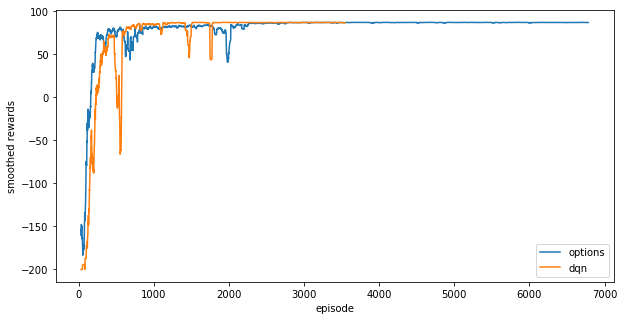

In [15]:
plotting.plot_multi_test(smoothing_window=30,
                             x_label="episode",
                             y_label="smoothed rewards",
                             curve_to_draw=[array,
                                            array2],
                             labels=["options", "dqn"]
                             )

In [19]:
with open('ep_len_4_3_3.txt') as f:
    array3 = []
    for line in f: # read rest of lines
        array3.append(int(line))

In [20]:
with open('ep_len_4_3_3_plain_dqn.txt') as f:
    array4 = []
    for line in f: # read rest of lines
        array4.append(int(line))

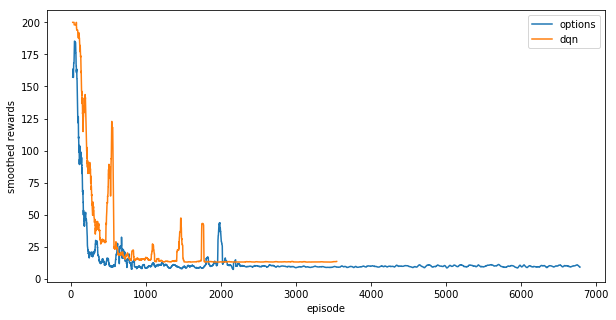

In [22]:
plotting.plot_multi_test(smoothing_window=30,
                             x_label="episode",
                             y_label="smoothed rewards",
                             curve_to_draw=[array3,
                                            array4],
                             labels=["options", "dqn"]
                             )